### Team 3 Task 27 ###

### Finding Correlation between weight, hight, BMI to rehspitalization grops ###

The prorpes of this task is to

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
# Define a functions to proccese the data and to classify the duration between the hospitalizations for the patients
# (using based in tasks 16-18)

def calculate_rehospitalizations(df, patient_col):
    """
    Calculates how many times each patient has been rehospitalized.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing patient and hospitalization data.
    patient_col : str
        The name of the column representing patient IDs.

    Returns:
    --------
    pd.DataFrame
        DataFrame with added column `hospitalization_count` indicating the number of hospitalizations for each patient.
    """
    df["hospitalization_count"] = df.groupby(patient_col)[patient_col].transform(
        "count"
    )
    return df


def calculate_duration_between_hospitalizations(
    df, patient_col, admission_col, release_col
):
    """
    Calculates the duration between each hospitalization for each patient based on the
    Release_Date of the previous hospitalization and the Admission_Entry_Date of the next one.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing patient and hospitalization data.
    patient_col : str
        The name of the column representing patient IDs.
    admission_col : str
        The name of the column representing admission entry dates.
    release_col : str
        The name of the column representing release dates.

    Returns:
    --------
    pd.DataFrame
        DataFrame with an added column `duration_between_hospitalizations` indicating
        the number of days between hospitalizations.
    """
    # Sort by patient_id and Admission_Entry_Date
    df = df.sort_values(by=[patient_col, admission_col])

    # Shift Release_Date to calculate time difference between the previous release and next admission
    df["previous_release"] = df.groupby(patient_col)[release_col].shift(1)

    # Calculate the duration between consecutive hospitalizations
    df["duration_between_hospitalizations"] = (
        df[admission_col] - df["previous_release"]
    ).dt.days

    return df


def classify_duration(df, duration_col):
    """
    Classifies the duration between hospitalizations into three quartiles: short, medium, and long.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing duration between hospitalizations.
    duration_col : str
        The name of the column representing the duration between hospitalizations.

    Returns:
    --------
    pd.DataFrame
        DataFrame with an added column `duration_classification` categorizing durations into short, medium, or long.
    """
    df_duration = df.dropna(subset=[duration_col])
    quartiles = df_duration[duration_col].quantile([0.33, 0.66])

    def classify_duration_value(duration):
        if duration <= quartiles[0.33]:
            return "short"
        elif duration <= quartiles[0.66]:
            return "medium"
        else:
            return "long"

    df_duration["duration_classification"] = df_duration[duration_col].apply(
        classify_duration_value
    )
    return df_duration


def process_rehospitalization_data(df, patient_col, admission_col, release_col):
    """
    Main function to process rehospitalization data, which calculates:
    1) How many times each patient was rehospitalized.
    2) Duration between each hospitalization.
    3) Classification of each duration between rehospitalization.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing patient and hospitalization data.
    patient_col : str
        The name of the column representing patient IDs.
    admission_col : str
        The name of the column representing admission entry dates.
    release_col : str
        The name of the column representing release dates.

    Returns:
    --------
    pd.DataFrame
        Processed DataFrame with the following columns:
        - hospitalization_count
        - duration_between_hospitalizations
        - duration_classification (short, medium, long)
    """
    # Convert admission and release dates to datetime
    df[admission_col] = pd.to_datetime(df[admission_col])
    df[release_col] = pd.to_datetime(df[release_col])

    # Step 1: Calculate the number of times each patient was rehospitalized
    df = calculate_rehospitalizations(df, patient_col)

    # Step 2: Calculate the duration between each hospitalization based on release and next admission
    df = calculate_duration_between_hospitalizations(
        df, patient_col, admission_col, release_col
    )

    # Step 3: Classify each duration between hospitalizations into quartiles
    df = classify_duration(df, "duration_between_hospitalizations")

    return df


In [99]:
rehospitalization_df = pd.read_excel("/content/rehospitalization.xlsx", sheet_name='hospitalization2')

processed_classifed_df = process_rehospitalization_data(rehospitalization_df, 'Patient', 'Admission_Entry_Date2', 'Release_Date2')
processed_classifed_df.head()


<ipython-input-98-2eeab8085da8>:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,...,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct,hospitalization_count,previous_release,duration_between_hospitalizations,duration_classification
2107,31,4,4285143,2020-07-26 09:01:59.213,2020-07-27 18:01:00,4,4314756,2020-08-08 13:36:33.263,2020-08-10 16:00:00,דחוף,...,10779.0,2,7865,7865,קרדיולוגיה הפרעות קצב,0,3,2020-07-31 15:45:00,7.0,medium
3614,31,4,4298122,2020-07-31 03:17:42.087,2020-07-31 15:45:00,4,4314756,2020-08-08 13:36:33.263,2020-08-10 16:00:00,דחוף,...,10779.0,2,7865,7865,קרדיולוגיה הפרעות קצב,0,3,2020-08-10 16:00:00,-3.0,short
7804,184,2,6245307,2022-10-21 20:40:30.750,2022-10-23 15:50:00,2,6304881,2022-11-14 19:10:56.910,2022-11-15 14:40:00,דחוף,...,11515.0,1,401,401,NaN,0,2,2022-10-23 15:50:00,22.0,long
2477,305,1,3877629,2020-01-04 16:16:04.103,2020-01-06 14:57:00,1,3951517,2020-02-04 14:02:27.643,2020-02-05 14:06:00,דחוף,...,6892.0,1,78609,78609,NaN,0,7,2020-01-23 13:59:00,12.0,long
8028,305,1,3905672,2020-01-16 03:20:07.073,2020-01-23 13:59:00,1,3951517,2020-02-04 14:02:27.643,2020-02-05 14:06:00,דחוף,...,6892.0,1,78609,78609,NaN,0,7,2020-02-05 14:06:00,-2.0,short


Next we will merge the two dataframe we have for preparing the data for the training

In [100]:
# Reading data for both dataframes, since Weight Height and BMI are located in different sheets
generalData_df = pd.read_excel("/content/rehospitalization.xlsx", sheet_name='GeneralData')

# Renaming the columns 'משקל' to 'Weight' and 'גובה' to 'Height'
generalData_df = generalData_df.rename(columns={'משקל': 'Weight', 'גובה': 'Height'})

# Merging the two dataframes on the 'Patient' column
# Merging the two dataframes using an inner join to ensure only the rows that exist in both dataframes are included
merged_df = pd.merge(processed_classifed_df[['Patient','duration_classification']], generalData_df[['Patient','Weight', 'Height', 'BMI']], on='Patient', how='inner')

merged_df.dropna(inplace=True)
merged_df.head()

,Patient,duration_classification,Weight,Height,BMI
0,31,medium,58.0,160.0,23.4
1,31,short,58.0,160.0,23.4
2,184,long,78.0,167.0,28.0
3,305,long,70.0,165.0,26.7
4,305,short,70.0,165.0,26.7


# We will implement a KNN - K nearest neibore model for clasiffication, and try to find the rehospitalization by groups

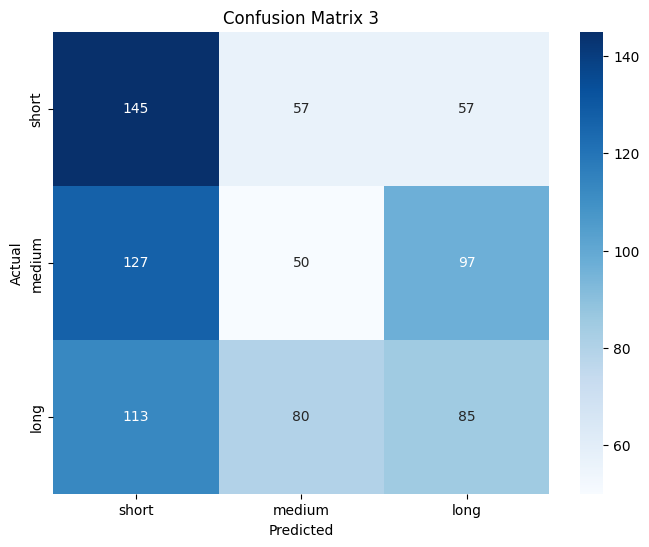

              precision    recall  f1-score   support

        long       0.38      0.56      0.45       259
      medium       0.27      0.18      0.22       274
       short       0.36      0.31      0.33       278

    accuracy                           0.35       811
   macro avg       0.33      0.35      0.33       811
weighted avg       0.33      0.35      0.33       811



In [101]:
from scipy import stats

# Remove outliers based on z-score
z_scores = np.abs(stats.zscore(merged_df[['Height', 'Weight', 'BMI']]))
df_no_outliers = merged_df[(z_scores < 3).all(axis=1)]

# Display the number of rows before and after outlier removal
before_outliers = merged_df.shape[0]
after_outliers = df_no_outliers.shape[0]

# Splitting the data again after removing outliers
X = df_no_outliers[['Height', 'Weight', 'BMI']]
y = df_no_outliers['duration_classification']

# Random seed
seed = 42

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implementing the KNN classifier
k=3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Predicting the test set
y_pred = knn.predict(X_test_scaled)

# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['short', 'medium', 'long'], yticklabels=['short', 'medium', 'long'])
plt.title(f"Confusion Matrix {k}")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Displaying the classification report
print(class_report)

The results aren't seens so good for KNN model, (k=3 choosed as the best parameter from experiments)

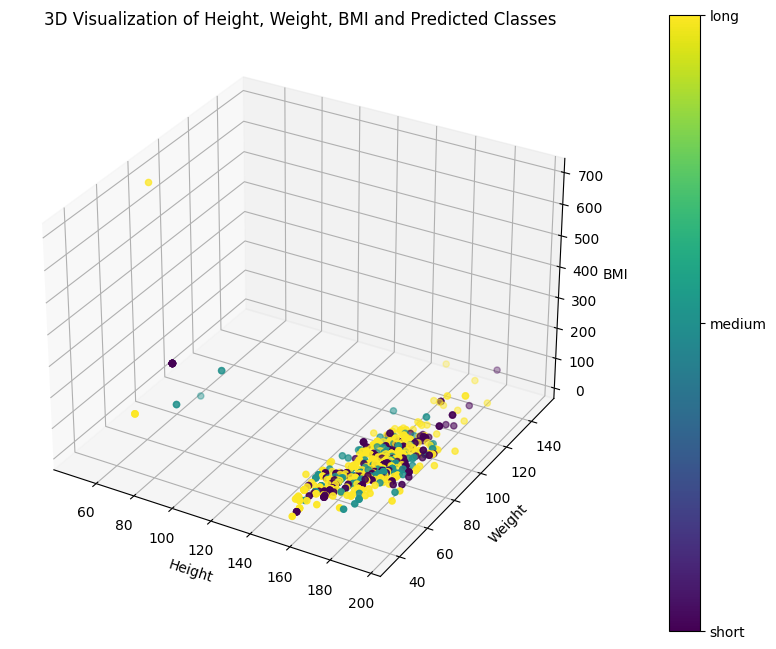

In [102]:
# Mapping 'short', 'medium', 'long' to numeric labels 0, 1, 2
class_mapping = {'short': 0, 'medium': 1, 'long': 2}
y_pred_mapped = pd.Series(y_pred).map(class_mapping)

# 3D Visualization with 3 distinct colors for the predicted classes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for predicted classes with 3 distinct colors
scatter = ax.scatter(X_test['Height'], X_test['Weight'], X_test['BMI'], c=y_pred_mapped, cmap='viridis', marker='o')

# Adding labels
ax.set_xlabel('Height')
ax.set_ylabel('Weight')
ax.set_zlabel('BMI')
ax.set_title('3D Visualization of Height, Weight, BMI and Predicted Classes')

# Adding a color bar with 3 distinct options
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['short', 'medium', 'long'])

plt.show()

The results are so satisfied with accuracy of 0.35 for the KNN model.

We will try different method with DL

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Encoding categorical data
encoder = LabelEncoder()
merged_df['duration_encoded'] = encoder.fit_transform(merged_df['duration_classification'])
# Convert labels to categorical one-hot encoding
y = to_categorical(merged_df['duration_encoded'])

# Selecting features
X = merged_df[['Height', 'Weight', 'BMI']].values

# Splitting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the deep learning model
model = Sequential()
model.add(Dense(256, input_dim=3, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compiling the model with lower learning rate
optimizer = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add early stopping for prevent overfitting the model
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint
history_nn = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=100, batch_size=16,
                    callbacks=[early_stopping, model_checkpoint])

# Predicting the test set
y_pred = model.predict(X_test_scaled)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3399 - loss: 1.1048 - val_accuracy: 0.3313 - val_loss: 1.1034
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3298 - loss: 1.1078 - val_accuracy: 0.3289 - val_loss: 1.1011
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3454 - loss: 1.1060 - val_accuracy: 0.3216 - val_loss: 1.0995
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3273 - loss: 1.1032 - val_accuracy: 0.3143 - val_loss: 1.0985
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3387 - loss: 1.0992 - val_accuracy: 0.3167 - val_loss: 1.0975
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3387 - loss: 1.1000 - val_accuracy: 0.3191 - val_loss: 1.0967
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3347 - loss: 1.1020 - val_accuracy: 0.3179 - val_loss: 1.0961
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3642 - loss: 1.0970 - val_accuracy: 0.3167

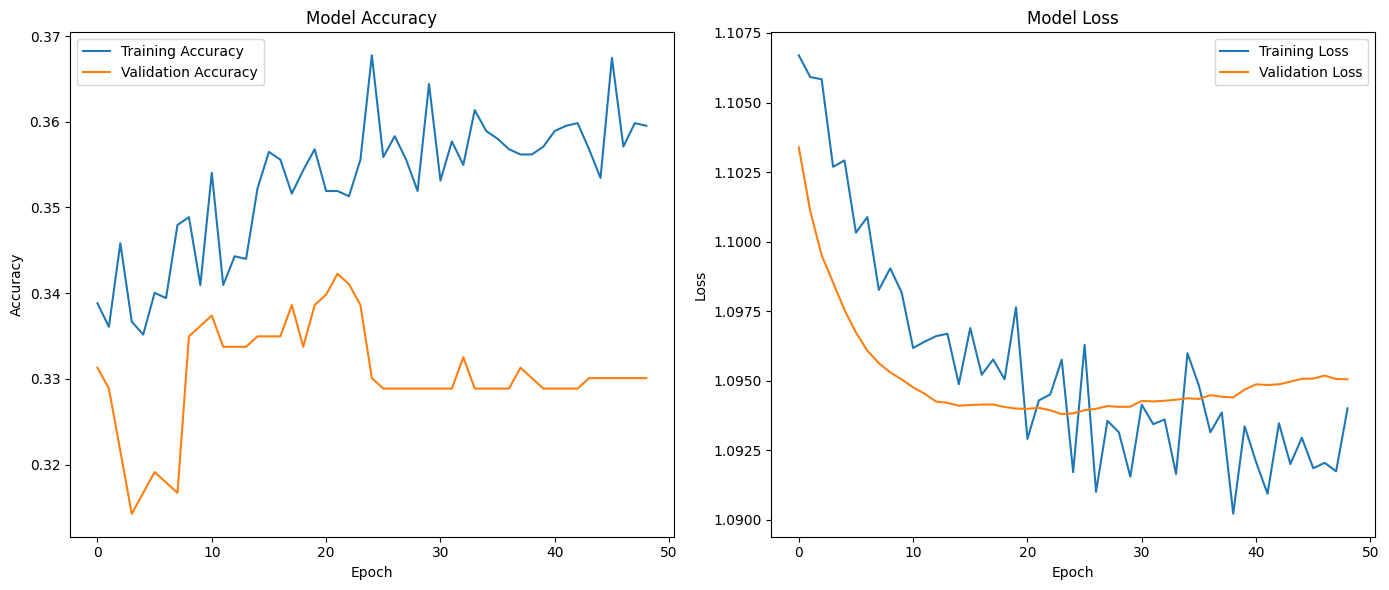

('              precision    recall  f1-score   support\n\n       short       0.31      0.77      0.44       247\n      medium       0.39      0.08      0.13       275\n        long       0.44      0.22      0.29       299\n\n    accuracy                           0.34       821\n   macro avg       0.38      0.36      0.29       821\nweighted avg       0.38      0.34      0.28       821\n',
 array([[190,  17,  40],
        [208,  22,  45],
        [215,  18,  66]]))

In [104]:
# Visualizing accuracy and loss
plt.figure(figsize=(14, 6))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_nn.history['accuracy'], label='Training Accuracy')
plt.plot(history_nn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_nn.history['loss'], label='Training Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Classification report and confusion matrix
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=['short', 'medium', 'long'])
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

report, conf_matrix

In [105]:
import plotly.express as px
import plotly.graph_objects as go

# Prepare the data for the table and visualization
metrics_data = pd.DataFrame({
    'Epoch': list(range(1, len(history_nn.history['accuracy']) + 1)),
    'Train Accuracy': history_nn.history['accuracy'],
    'Test Accuracy': history_nn.history['val_accuracy'],
    'Train Loss': history_nn.history['loss'],
    'Test Loss': history_nn.history['val_loss']
})

# Create an interactive table
fig_table = go.Figure(data=[go.Table(
    header=dict(values=list(metrics_data.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[metrics_data[col] for col in metrics_data.columns],
               fill_color='lavender',
               align='left'))
])

# Create the accuracy graph with hovermode set to 'x unified'
fig_accuracy = go.Figure()

fig_accuracy.add_trace(go.Scatter(
    x=metrics_data['Epoch'], y=metrics_data['Train Accuracy'],
    mode='lines', name='Train Accuracy'
))

fig_accuracy.add_trace(go.Scatter(
    x=metrics_data['Epoch'], y=metrics_data['Test Accuracy'],
    mode='lines', name='Test Accuracy'
))

fig_accuracy.update_layout(
    title='Model Accuracy Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    hovermode='x unified'  # This enables the unified tooltip
)

# Create the loss graph with hovermode set to 'x unified'
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(
    x=metrics_data['Epoch'], y=metrics_data['Train Loss'],
    mode='lines', name='Train Loss'
))

fig_loss.add_trace(go.Scatter(
    x=metrics_data['Epoch'], y=metrics_data['Test Loss'],
    mode='lines', name='Test Loss'
))

fig_loss.update_layout(
    title='Model Loss Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    hovermode='x unified'  # This enables the unified tooltip
)

# Show the table and the plots
fig_table.show()
fig_accuracy.show()
fig_loss.show()


Model performance for the loss looks good, and not over or under-fitted due to early-stopping, dropout, and adjusting the LR for Adam optimizer.

Also, the Accuracy doesn't seem to rise and improve which indicates that there is no correlation between the variables.

Next, we will present model metrics

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# Predictions
y_true_classes = y_test.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate ROC and PR curves
fpr, tpr, _ = roc_curve(y_true_classes, y_pred_classes, pos_label=2)
precision, recall, _ = precision_recall_curve(y_true_classes, y_pred_classes, pos_label=2)

# AUC for ROC and PR
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)


In [107]:
import plotly.graph_objects as go

# Plot ROC curve using Plotly
fig_roc = go.Figure()

# Add ROC curve
fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {roc_auc:.2f})'))

# Add diagonal random guess line
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random Guess'))

# Update layout
fig_roc.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    hovermode='x unified'
)

# Show ROC plot
fig_roc.show()

In [108]:
# Plot Precision-Recall curve using Plotly
fig_pr = go.Figure()

# Add PR curve
fig_pr.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name=f'PR Curve (AUC = {pr_auc:.2f})'))

# Update layout
fig_pr.update_layout(
    title='Precision-Recall (PR) Curve',
    xaxis_title='Recall',
    yaxis_title='Precision',
    hovermode='x unified'
)

# Show PR plot
fig_pr.show()

# Summary of the Work

In this workflow, we tried to classify `duration_classification` into three categories (`short`, `medium`, `long`) using features such as `Height`, `Weight`, and `BMI`. After building an initial model, the performance was unsatisfactory. We applied various strategies to improve the model's learning capacity, such as:

* Data normalization.
* Adding more complex layers (Batch Normalization, Dropout).
* Adjusting the learning rate and increasing the training epochs.

Despite these enhancements, the model's learning might still be inadequate. This suggests that there could be no strong correlation between physical attributes like `height`, `weight`, and `BMI` and the classification we are trying to predict.

### Why There Might Be No Correlation
The features (`Height`, `Weight`, `BMI`) are typically used for predicting health or fitness-related outcomes, but may not be relevant for categorizing durations such as `short`, `medium`, or `long`. These duration classes might depend on factors outside of body measurements, such as behavior, activity levels, or even external conditions that aren't reflected in physical characteristics.

In summary, it's possible that the features provided are not significant predictors of the target variable, leading to poor model performance even with advanced techniques. we may need to explore other features that are more aligned with `duration_classification`.